In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from data_parse import get_geoparse
from scipy.stats import linregress
from models import fit_timecourse_ols

In [2]:
expression_df, phenotype_df = get_geoparse()
phenotype_df["hours"] = (
    phenotype_df["title"]
    .str.extract(r"(\d+(?:\.\d+)?)\s*hours", expand=False)
    .astype(float)
)
phenotype_df["ctrl"] = phenotype_df["title"].str.contains(
    "negative control", case=False, na=False
)
phenotype_df = phenotype_df[['hours', 'ctrl']]

30-Dec-2025 14:46:53 INFO GEOparse - Parsing ./geo_data/GSE6207_family.soft.gz: 
30-Dec-2025 14:46:53 DEBUG GEOparse - DATABASE: GeoMiame
30-Dec-2025 14:46:53 DEBUG GEOparse - SERIES: GSE6207
30-Dec-2025 14:46:53 DEBUG GEOparse - PLATFORM: GPL570
/Users/connorott/PycharmProjects/bioml/.venv/lib/python3.12/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
30-Dec-2025 14:46:55 DEBUG GEOparse - SAMPLE: GSM143385
30-Dec-2025 14:46:55 DEBUG GEOparse - SAMPLE: GSM143386
30-Dec-2025 14:46:55 DEBUG GEOparse - SAMPLE: GSM143387
30-Dec-2025 14:46:55 DEBUG GEOparse - SAMPLE: GSM143388
30-Dec-2025 14:46:55 DEBUG GEOparse - SAMPLE: GSM143389
30-Dec-2025 14:46:55 DEBUG GEOparse - SAMPLE: GSM143390
30-Dec-2025 14:46:55 DEBUG GEOparse - SAMPLE: GSM143391
30-Dec-2025 14:46:55 DEBUG GEOparse - SAMPLE: GSM143392
30-Dec-2025 14:46:55 DEBUG GEOparse - SAMPLE:

Precheck data for expression distribution

In [ ]:
plt.figure(figsize=(8, 7))
expression_df.hist(bins=100)
plt.title("Histogram of Samples")
plt.tight_layout()
plt.figure(figsize=(8, 7))
expression_df.boxplot()
plt.title("Boxplot of Samples")
plt.tight_layout()

PCA Analysis of Variance:
    Compare time and treatment to PC 1 & 2

In [ ]:
samples = phenotype_df.index
X = expression_df.T
assert all(X.index == phenotype_df.index)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(
    X_pca,
    index=X.index,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

pca_df = pca_df.join(phenotype_df)
pca_df['hours_cat'] = pca_df['hours'].astype(str)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="hours_cat",
    palette="viridis",
    s=80
)
plt.title("PCA of samples (colored by time)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="ctrl",
    style="ctrl",
    s=80
)
plt.title("PCA of samples (colored by treatment)")
plt.tight_layout()
plt.show()

Minimal Filtering:
    Only remove genes with pure background signal or low variance between samples

Genes after background filter: 46943
Genes after variance filter: 34552


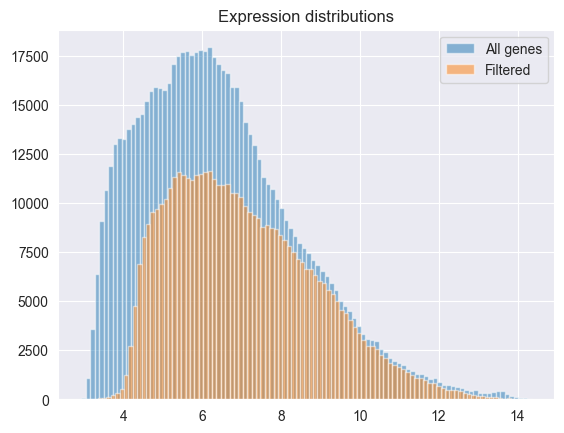

In [3]:
MIN_EXPR = 4.5  # background cutoff
background_filter = (expression_df > MIN_EXPR).any(axis=1)
exp_filter = expression_df.loc[background_filter]
print(f"Genes after background filter: {exp_filter.shape[0]}")

MIN_VAR = 0.01
var_filter = exp_filter.var(axis=1) > MIN_VAR
exp_filter = exp_filter.loc[var_filter]
print(f"Genes after variance filter: {exp_filter.shape[0]}")
plt.hist(expression_df.values.flatten(), bins=100, alpha=0.5, label="All genes")
plt.hist(exp_filter.values.flatten(), bins=100, alpha=0.5, label="Filtered")
plt.legend()
plt.title("Expression distributions")
plt.show()

In [4]:
results = fit_timecourse_ols(
     expr_gene_by_sample=exp_filter,
     pheno=phenotype_df,
     time_col="hours",
     type_col="ctrl",
     center_time=True,
     add_timepoint_effects=True,
 )

Volcano Plots

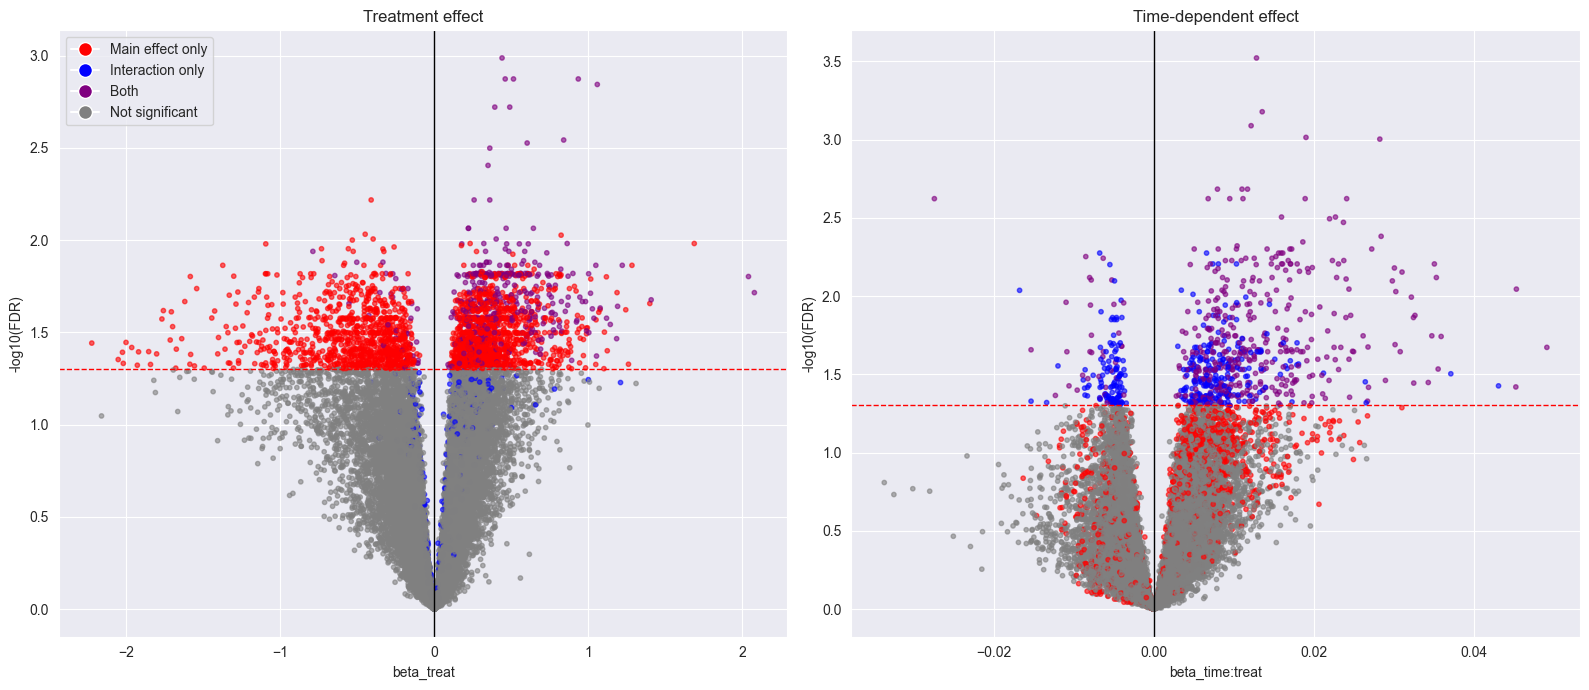

In [6]:
res = results.copy()
res["abs_beta_treat"] = res["beta_treat"].abs()
res["abs_beta_interaction"] = res["beta_time_c:treat"].abs()
res["log10_fdr_treat"] = -np.log10(res["fdr_treat"] + 1e-300)
res["log10_fdr_interaction"] = -np.log10(res["fdr_interaction"] + 1e-300)
alpha = 0.05
alpha = 0.05
sig_treat = res['fdr_treat'] < alpha
sig_int = res['fdr_interaction'] < alpha
conditions = [
    (sig_treat & ~sig_int),   # only treatment
    (~sig_treat & sig_int),   # only interaction
    (sig_treat & sig_int),    # both
]
colors = ['red', 'blue', 'purple']
labels = ['Main effect only', 'Interaction only', 'Both']
res['category'] = np.select(conditions, labels, default='None')
color_map = {
    'Main effect only': 'red',
    'Interaction only': 'blue',
    'Both': 'purple',
    'None': 'gray'
}
plot_colors = res['category'].map(color_map)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Treatment
axes[0].scatter(
    res["beta_treat"],
    res["log10_fdr_treat"],
    s=10,
    alpha=0.6,
    c=plot_colors,
)
axes[0].axvline(0, color="black", lw=1)
axes[0].axhline(-np.log10(0.05), color="red", ls="--", lw=1)
axes[0].set_xlabel("beta_treat")
axes[0].set_ylabel("-log10(FDR)")
axes[0].set_title("Treatment effect")
handles = [plt.Line2D([0], [0], marker='o', color='w', label=lab,
                      markerfacecolor=col, markersize=10) for lab, col in zip(labels, colors)]
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Not significant',
                          markerfacecolor='gray', markersize=10))
axes[0].legend(handles=handles, loc='upper left', frameon=True)

# Interaction
plt.scatter(
    res["beta_time_c:treat"],
    res["log10_fdr_interaction"],
    s=10,
    alpha=0.6,
    c=plot_colors,
)
axes[1].axvline(0, color="black", lw=1)
axes[1].axhline(-np.log10(0.05), color="red", ls="--", lw=1)
axes[1].set_xlabel("beta_time:treat")
axes[1].set_ylabel("-log10(FDR)")
axes[1].set_title("Time-dependent effect")
plt.tight_layout()
plt.show()

In [7]:
hits = res[(res['fdr_treat'] < 0.05) | (res['fdr_interaction'] < 0.05)].copy()
main_only = res[(res['fdr_treat'] < 0.05) & (res['fdr_interaction'] >= 0.05)]
interaction_only = res[(res['fdr_interaction'] < 0.05) & (res['fdr_treat'] >= 0.05)]
both = res[(res['fdr_treat'] < 0.05) & (res['fdr_interaction'] < 0.05)]

print(f"Total responsive genes: {len(hits)}")
print(f"Main effect only: {len(main_only)}")
print(f"Interaction only: {len(interaction_only)}")
print(f"Both: {len(both)}")

Total responsive genes: 2807
Main effect only: 2048
Interaction only: 320
Both: 439


Split Interaction into response type categories

In [16]:
samples = phenotype_df[~phenotype_df['ctrl']].index
time = phenotype_df[~phenotype_df['ctrl']]['hours']
interaction_genes = interaction_only.index
popts=[]
t_norm = time / (time.max() - time.min() + 1e-8)

for gene, y in exp_filter.loc[interaction_genes, samples].iterrows():
    # Design matrix: [1, t, t²]
    X = np.column_stack([np.ones_like(t_norm), t_norm, t_norm ** 2])

    # Fit quadratic model using ordinary least squares
    coeffs, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    a, b, c = coeffs  # y ≈ a + b*t + c*t²

    # Check if quadratic term is significant
    # Simple way: compare R² of linear vs quadratic
    # Linear fit
    slope, intercept, r_linear, _, _ = linregress(t_norm, y)
    ss_tot = np.sum((y - y.mean()) ** 2)
    ss_res_linear = np.sum((y - (slope * t_norm + intercept)) ** 2)
    r2_linear = 1 - ss_res_linear / ss_tot

    # Quadratic residuals
    y_pred_quad = X @ coeffs
    ss_res_quad = np.sum((y - y_pred_quad) ** 2)
    r2_quad = 1 - ss_res_quad / ss_tot
    improvement = r2_quad - r2_linear

    if c < 0 and improvement > 0.05:  # significant improvement and concave
        group = "early_response"
    # If quadratic term is large and positive → convex
    elif c > 0 and improvement > 0.05:
        group = "late_response"
    # If quadratic doesn't improve much → linear is sufficient
    elif improvement < 0.03:
        group = "sustained_linear"
    else:
        group = "no_clear_pattern"

    improvement = r2_quad - r2_linear
    popts.append({
        'gene': gene,
        'group': group,
        'y': y
    })


d=1



